In [1]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import mdtraj as md
import math
from cgae.utils import write_traj, save_traj
from cgae.cgae_dense import *
import numpy as np

In [2]:
# hyperparameters 
par = {}
par["n_atom"] = 32
par["N_cg"] = 3
par["lr"]  = 1e-4
par["batch_size"] = 20  
par["Tstart"] = 4.0      # starting temperature 
par["max_epoch"] = 800
par["n_mol"] = 1         # number of molecules, 
par["epoch_regularize"] = 400    # first epoch to include instataneous force regularization
par["rho"] = 0.005       # relative weight for force regularization
par["decay_ratio"] = 0.4 # the decay rate for the temperature annealing 
device = 'cpu'

In [4]:
import mdshare
import pyemma

pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-1-250ns-nowater.xtc', working_directory='data')

feat = pyemma.coordinates.featurizer(pdb)
traj = pyemma.coordinates.load(files, features=feat)

/home/wwj/anaconda3/envs/htvs/lib/python3.5/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.6, you have 2.5.4.
  .format(latest=latest, current=current), category=UserWarning)
/home/wwj/anaconda3/envs/htvs/lib/python3.5/site-packages/pyemma/coordinates/data/featurization/featurizer.py:884: UserWarning: You have not selected any features. Returning plain coordinates.
  warnings.warn("You have not selected any features. Returning plain coordinates.")


In [26]:
N_cg = 6

# hyperparan 
par = {}
par["n_atom"] = 22
par["N_cg"] = N_cg
par["lr"]  = 5e-4
par["batch_size"] = 20
par["par_init"] = 4.0 
par["anneal_protocol"] = "linear" # ["linear", "exponential"]
par["Tstart"] = 1.0
par["max_epoch"] = 50
par["n_mol"] = 1
par["epoch_fm"] = 500
par["fm_ratio"] = 0.008
par["decay_ratio"] = 0.5

# load data 
peptide = md.load("data/alanine-dipeptide-nowater.pdb")
peptide_top = peptide .top.to_dataframe()[0]
peptide_element = peptide_top['element'].values.tolist()

# construct time lag 
dt = 0
traj_0 = traj[:50000-dt] * 10
#force = force[:3000-dt]
traj_tau = traj[-(50000-dt):] * 10

print("finished loading data")

N_cg = par["N_cg"]
n_atom = par["n_atom"]
n_mol = par["n_mol"]
batch_size = par["batch_size"]
n_batch = int(traj_0.shape[0] // batch_size)
n_sample = n_batch * batch_size
xyz = traj_0[:n_sample].reshape(-1, batch_size, n_mol, n_atom, 3)[::2]
device = "cpu"

finished loading data


In [21]:
enc = Encoder(in_dim=n_atom, out_dim=N_cg, hard=False, device=device).to(device)
dec = Decoder(in_dim=N_cg, out_dim=n_atom).to(device)

t0 = par["Tstart"]
tmin = 0.2
temp = np.linspace(0, par["max_epoch"], par["max_epoch"] )

decay_epoch = int(par["max_epoch"] * par["decay_ratio"])
t_sched = t0 * np.exp(-temp/decay_epoch ) +  tmin
t_sched = torch.Tensor(t_sched).to(device)

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=par["lr"]) 

loss_log = []
loss_ae_log = []
loss_fm_log = []
std_fm_log = []


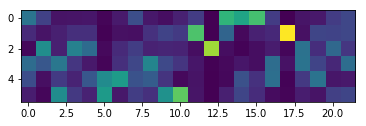

epoch 0 loss:  263.879


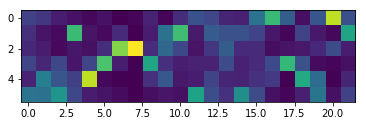

epoch 1 loss:  3.077


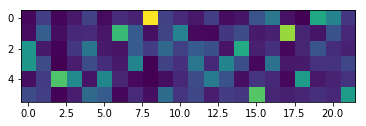

epoch 2 loss:  1.447


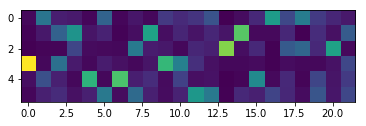

epoch 3 loss:  1.438


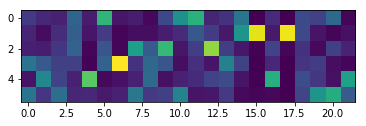

epoch 4 loss:  1.418


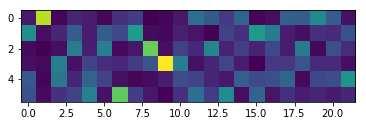

epoch 5 loss:  1.388


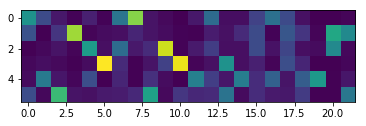

epoch 6 loss:  1.336


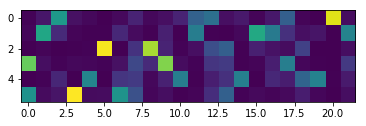

epoch 7 loss:  1.265


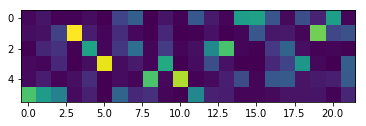

epoch 8 loss:  1.143


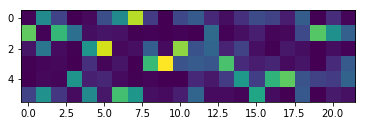

epoch 9 loss:  0.969


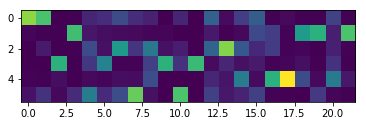

epoch 10 loss:  0.772


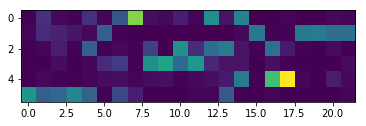

epoch 11 loss:  0.600


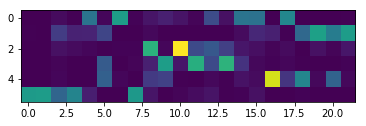

epoch 12 loss:  0.473


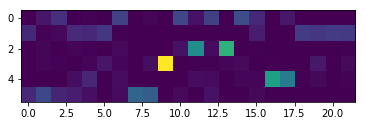

epoch 13 loss:  0.395


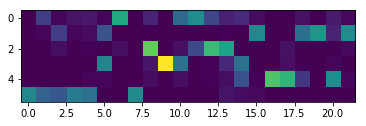

epoch 14 loss:  0.347


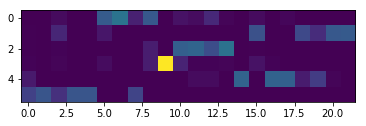

epoch 15 loss:  0.315


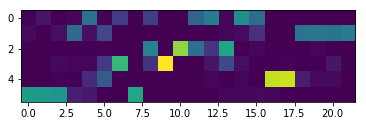

epoch 16 loss:  0.293


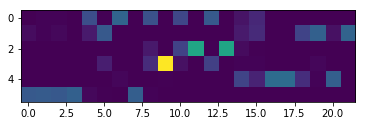

epoch 17 loss:  0.276


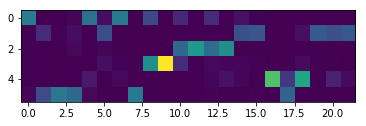

epoch 18 loss:  0.265


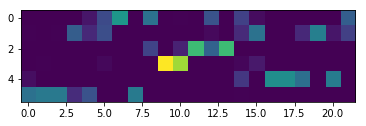

epoch 19 loss:  0.255


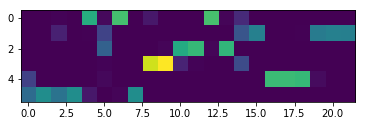

epoch 20 loss:  0.245


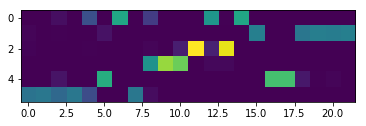

epoch 21 loss:  0.236


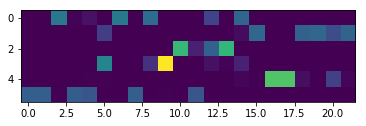

epoch 22 loss:  0.229


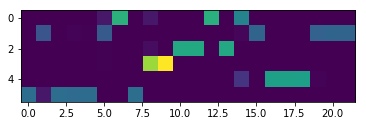

epoch 23 loss:  0.221


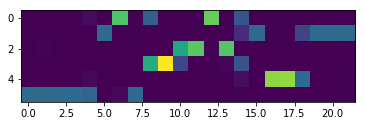

epoch 24 loss:  0.216


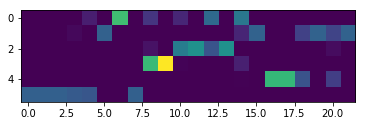

epoch 25 loss:  0.210


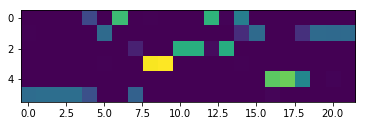

epoch 26 loss:  0.205


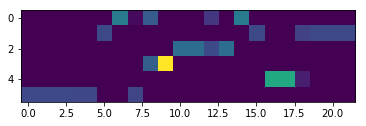

epoch 27 loss:  0.202


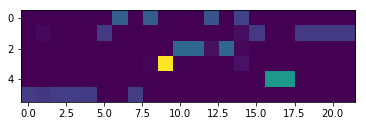

epoch 28 loss:  0.196


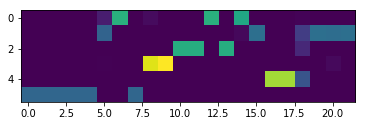

epoch 29 loss:  0.193


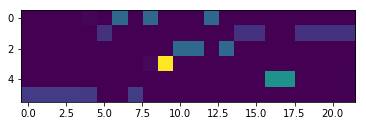

epoch 30 loss:  0.190


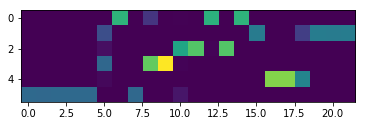

epoch 31 loss:  0.186


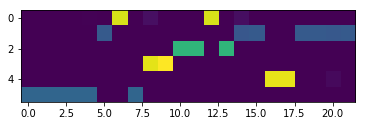

epoch 32 loss:  0.184


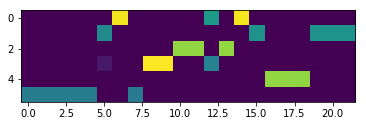

epoch 33 loss:  0.182


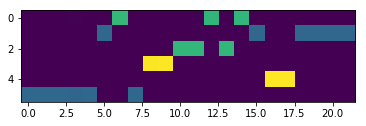

epoch 34 loss:  0.178


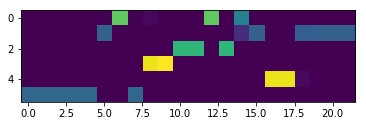

epoch 35 loss:  0.176


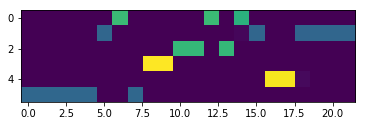

epoch 36 loss:  0.175


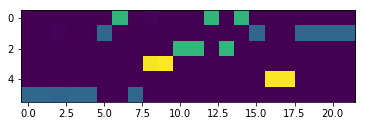

epoch 37 loss:  0.172


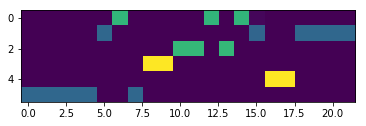

epoch 38 loss:  0.171


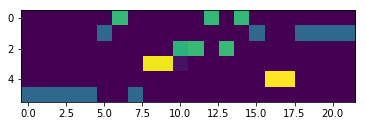

epoch 39 loss:  0.169


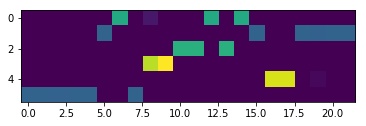

epoch 40 loss:  0.168


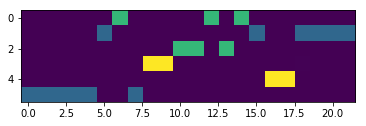

epoch 41 loss:  0.167


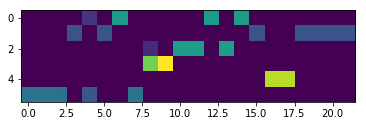

epoch 42 loss:  0.165


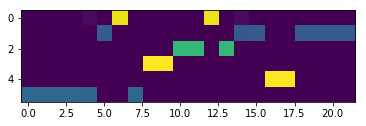

epoch 43 loss:  0.165


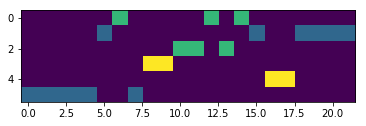

epoch 44 loss:  0.164


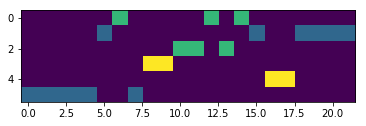

epoch 45 loss:  0.162


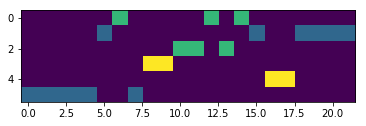

epoch 46 loss:  0.162


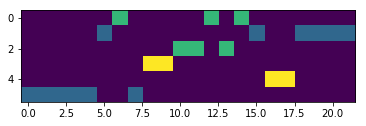

epoch 47 loss:  0.161


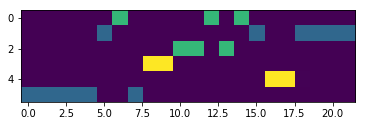

epoch 48 loss:  0.160


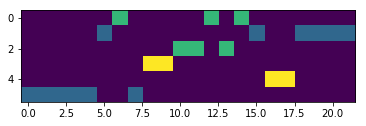

epoch 49 loss:  0.160


In [22]:
for epoch in range(par["max_epoch"]):
        
        loss_epoch = 0.0  
        loss_ae_epoch = 0.0
        loss_fm_epoch = 0.0
        std_fm_epoch = 0.0
            
        for i, batch in enumerate(xyz):
            batch = torch.Tensor(batch.reshape(-1, n_atom, 3)).to(device) 
            cg_xyz = enc(batch, t_sched[epoch])
            #CG = Encoder.CG.pinverse().t()
            #CG = gumbel_softmax(Encoder.weight1.t(), 0.1, device=device).t()

            decoded = dec(cg_xyz)
            loss_ae = criterion(decoded, batch)
                
            loss = loss_ae

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_epoch += loss.item()
            loss_ae_epoch += loss_ae.item()

        
        loss_epoch = loss_epoch/xyz.shape[0]
        loss_ae_epoch = loss_ae_epoch/xyz.shape[0]

        loss_log.append(loss_epoch)
        loss_ae_log.append(loss_ae_epoch)

        
        plt.imshow(enc.CG.detach().cpu().numpy())
        plt.show()

        print("epoch %d loss:  %.3f"  % (epoch,  loss_ae_epoch))


In [23]:
# Get decoded trajectory 
decoded_traj = []
cg_traj = []
for i, batch in enumerate(traj):
    batch = torch.Tensor(batch.reshape(-1, n_atom, 3)).to(device) 
    cg_xyz = enc(batch,  0.1)
    decoded = dec(cg_xyz)
    cg_traj.append(cg_xyz.detach().cpu().numpy())
    decoded_traj.append(decoded.detach().cpu().numpy())

In [27]:
save_traj(np.array(decoded_traj).reshape(-1, len(otp_element), 3), peptide_element, 'data/decoded6.xyz')
save_traj(np.array(cg_traj).reshape(-1, N_cg, 3), [6]*N_cg, 'data/cg6.xyz')

In [29]:
# Plot Ramachandra plots 
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions() 
data = pyemma.coordinates.load('data/decoded6.xyz', features=feat)

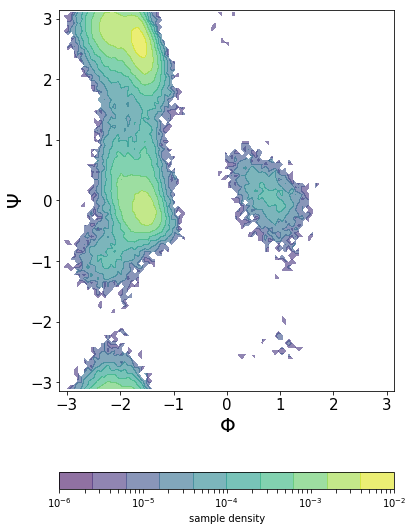

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(6, 10), sharex=True, sharey=True)
pyemma.plots.plot_density(data[:,0], data[:,1], ax=axes, ncontours=10, cmap='viridis', 
                          cbar_orientation='horizontal' , alpha=0.6, logscale=True)
axes.set_xlim((-3.14, 3.14))
axes.set_ylim((-3.14, 3.14))
axes.set_ylabel('$\Psi$', fontsize=20)
axes.set_xlabel('$\Phi$', fontsize=20)
axes.tick_params(axis='both', which='major', labelsize=15)
plt.show()